In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split

In [4]:
dataset = read_csv('../datasets/mnist_data/train.csv')
dataset = dataset.values

   label  pixel0  pixel1  pixel2  pixel3    ...     pixel779  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0       0    ...            0         0         0         0         0
1      0       0       0       0       0    ...            0         0         0         0         0
2      1       0       0       0       0    ...            0         0         0         0         0
3      4       0       0       0       0    ...            0         0         0         0         0
4      0       0       0       0       0    ...            0         0         0         0         0

[5 rows x 785 columns]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset[:, 1:], dataset[:, 0], test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [38]:
X_train, X_test = X_train/255, X_test/255

In [17]:
print(y_train[:10])

[0 1 4 1 7 5 1 4 5 1]


In [135]:
class NeuralNetwork:
    
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.N = X_train.shape[0]
        self.INPUT_DIM = X_train.shape[1]
        self.OUTPUT_DIM = len(np.unique(y_train))
        self.H1_DIM = 256
        self.H2_DIM = 64
        self.losses = list()
        
        # Initialize Weights
        self.W1 = np.random.randn(self.INPUT_DIM, self.H1_DIM)
        self.b1 = np.zeros((1, self.H1_DIM))
        
        self.W2 = np.random.randn(self.H1_DIM, self.H2_DIM)
        self.b2 = np.zeros((1, self.H2_DIM))
        
        self.W3 = np.random.randn(self.H2_DIM, self.OUTPUT_DIM)
        self.b3 = np.zeros((1, self.OUTPUT_DIM))
    
    
    def forward(self, X):
        Z1 = X.dot(self.W1) + self.b1 # (N,256) = (N,784).dot(784,256) + (1,256)
        A1 = self.sigmoid(Z1) # (N,256)
        Z2 = A1.dot(self.W2) + self.b2 # (N,64) = (N,256).dot(256,64) + (1,64)
        A2 = self.sigmoid(Z2) # (N,64)
        Z3 = A2.dot(self.W3) + self.b3 # (N,10) = (N,64).dot(64,10) + (1,10)
        yhat = self.softmax(Z3)
        
        self.activation_outputs = (A1, A2, yhat)
        return yhat
    
    
    def backward(self, X, y, yhat, learning_rate=0.01):
        A1, A2, yhat = self.activation_outputs
        
        # Compute Gradients
        delta3 = yhat - y
        dldw3  = A2.T.dot(delta3)
        dldb3  = delta3.sum(axis=0, keepdims=True)
        
        
        delta2 = delta3.dot(self.W3.T) * (A2 * (1 - A2))
        dldw2  = A1.T.dot(delta2)
        dldb2  = delta2.sum(axis=0, keepdims=True)
        
        delta1 = delta2.dot(self.W2.T) * (A1 * (1 - A1))
        dldw1  = X.T.dot(delta1)
        dldb1  = delta1.sum(axis=0, keepdims=True)
        
        # Update Weights
        self.W3 -= dldw3 * learning_rate
        self.b3 -= dldb3 * learning_rate
        
        self.W2 -= dldw2 * learning_rate
        self.b2 -= dldb2 * learning_rate
        
        self.W1 -= dldw1 * learning_rate
        self.b1 -= dldb1 * learning_rate
    
    
    def get_one_hot_vector(self, labels):
        distinct_labels = np.unique(labels)
        n_classes = len(distinct_labels)
        one_hot_vector = np.zeros((labels.shape[0], n_classes))
        for i,label in enumerate(labels):
            one_hot_vector[i, label] = 1
        return one_hot_vector
    
    
    def compute_loss(self, y, yhat):
        return -np.sum(y * np.log(yhat))
    
    
    def accuracy(self, labels, predictions):
        return (labels==predictions).mean()
    
    
    def predict(self, test):
        yhat = self.forward(test)
        preds = np.argmax(yhat, axis=1)
        return preds
    
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def sigmoid_derivative(self, z):
        y = self.sigmoid(z)
        return y * (1-y)
    
    
    def softmax(self, z):
        return np.exp(z) / (np.exp(z).sum(axis=1, keepdims=True))
    
    
    def train(self, learning_rate=0.01, epochs=10, batch_size=128):
        y_one_hot_vector = self.get_one_hot_vector(self.y_train)
        
        for e in range(epochs):
            size = 0
            while size + batch_size < self.N:
                x_batch = self.X_train[size : size + batch_size]
                y_batch = self.y_train[size : size + batch_size]
                size += batch_size
                
                y_batch_one_hot = self.get_one_hot_vector(y_batch)
                yhat_batch = self.forward(x_batch)
                self.backward(x_batch, y_batch_one_hot, yhat_batch, learning_rate)
            
            yhat = self.forward(self.X_train)
            self.losses.append(self.compute_loss(y_one_hot_vector, yhat))
            print("Loss at Epoch [{}]: {}".format(e, self.losses[-1]))
    
    

In [154]:
nn = NeuralNetwork(X_train, y_train)

In [155]:
nn.INPUT_DIM, nn.H1_DIM, nn.H2_DIM, nn.OUTPUT_DIM

(784, 256, 64, 10)

In [156]:
print("First Loss: ", nn.compute_loss(nn.get_one_hot_vector(nn.y_train), nn.forward(nn.X_train)))

First Loss:  214462.0346927005


In [160]:
nn.train(learning_rate=0.01, epochs=20, batch_size=128)

Loss at Epoch [0]: 1937.4164924411657
Loss at Epoch [1]: 1734.053957442213
Loss at Epoch [2]: 1536.2148430557713
Loss at Epoch [3]: 1473.031505283338
Loss at Epoch [4]: 1400.4371567963947
Loss at Epoch [5]: 1341.307623633659
Loss at Epoch [6]: 1292.3660549402587
Loss at Epoch [7]: 1248.692368803363
Loss at Epoch [8]: 1206.7898986306006
Loss at Epoch [9]: 1166.16487281652
Loss at Epoch [10]: 1128.2215442018905
Loss at Epoch [11]: 1087.9718763014741
Loss at Epoch [12]: 1048.684750757201
Loss at Epoch [13]: 1014.6655038274299
Loss at Epoch [14]: 982.1889447416379
Loss at Epoch [15]: 948.8865376845275
Loss at Epoch [16]: 916.0771373512822
Loss at Epoch [17]: 884.7610106447277
Loss at Epoch [18]: 854.6268056635456
Loss at Epoch [19]: 829.5907944915217


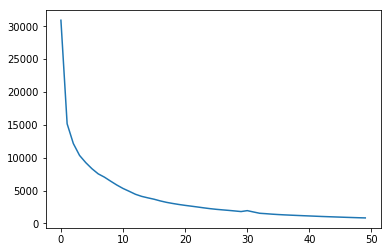

In [167]:
plt.figure()
plt.plot(nn.losses)
plt.show()

In [164]:
preds = nn.predict(X_test)
print("Testing Acc: ", nn.accuracy(y_test, preds))

Testing Acc:  0.9298809523809524


In [165]:
train_preds = nn.predict(X_train)
print("Training Acc:", nn.accuracy(y_train, train_preds))

Training Acc: 0.9947619047619047


In [166]:
print("Model has been overfitted!")

Model has been overfitted!
